In [1]:
# imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('fivethirtyeight')
import math
import seaborn as sns
from datetime import datetime

In [82]:
df = pd.read_excel('Data/Time Series Data.xlsx', index_col = 'Day')
df = df

In [9]:
def macd(signals):
    
    
    signals['ma1']=signals['Close'].rolling(window=ma1,min_periods=1,center=False).mean()
    signals['ma2']=signals['Close'].rolling(window=ma2,min_periods=1,center=False).mean()
    
    return signals



# In[3]:
#signal generation
#when the short moving average is larger than long moving average, we long and hold
#when the short moving average is smaller than long moving average, we clear positions
#the logic behind this is that the momentum has more impact on short moving average
#we can subtract short moving average from long moving average
#the difference between is sometimes positive, it sometimes becomes negative
#thats why it is named as moving average converge/diverge oscillator

def signal_generation(df,method):
    
    signals=method(df)
    signals['positions']=0

    #positions becomes and stays one once the short moving average is above long moving average
    signals['positions'][ma1:]=np.where(signals['ma1'][ma1:]>=signals['ma2'][ma1:],1,0)

    #as positions only imply the holding
    #we take the difference to generate real trade signal
    signals['signals']=signals['positions'].diff()

    #oscillator is the difference between two moving average
    #when it is positive, we long, vice versa
    signals['oscillator']=signals['ma1']-signals['ma2']

    return signals



# In[4]:

#plotting the backtesting result
def plot(new, ticker):
    
    #the first plot is the actual close price with long/short positions
    fig=plt.figure()
    ax=fig.add_subplot(111)
    
    new['Close'].plot(label=ticker)
    ax.plot(new.loc[new['signals']==1].index,new['Close'][new['signals']==1],label='LONG',lw=0,marker='^',c='g')
    ax.plot(new.loc[new['signals']==-1].index,new['Close'][new['signals']==-1],label='SHORT',lw=0,marker='v',c='r')

    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Positions')
    
    plt.show()
    
    #the second plot is long/short moving average with oscillator
    #note that i use bar chart for oscillator
    fig=plt.figure()
    cx=fig.add_subplot(211)

    new['oscillator'].plot(kind='bar',color='r')

    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks([])
    plt.xlabel('')
    plt.title('MACD Oscillator')

    bx=fig.add_subplot(212)

    new['ma1'].plot(label='ma1')
    new['ma2'].plot(label='ma2',linestyle=':')
    
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    
# In[5]:

def main():
    
    #input the long moving average and short moving average period
    #for the classic MACD, it is 12 and 26
    #once a upon a time you got six trading days in a week
    #so it is two week moving average versus one month moving average
    #for now, the ideal choice would be 10 and 21
    
    global ma1,ma2,stdate,eddate,ticker,slicer

    #macd is easy and effective
    #there is just one issue
    #entry signal is always late
    #watch out for downward EMA spirals!
    ma1=int(input('ma1:'))
    ma2=int(input('ma2:'))
    stdate=input('start date in format yyyy-mm-dd:')
    eddate=input('end date in format yyyy-mm-dd:')
    ticker=input('ticker:')

    #slicing the downloaded dataset
    #if the dataset is too large, backtesting plot would look messy
    #you get too many markers cluster together
    slicer=int(input('slicing:'))

    #downloading data
    df_init=pd.read_excel('Data/Time Series Data.xlsx', index_col = 'Day')
    df = df_init['Series 1']
    
    new=signal_generation(df,macd)
    new=new[slicer:]
    plot(new, ticker)


#how to calculate stats could be found from my other code called Heikin-Ashi
# https://github.com/je-suis-tm/quant-trading/blob/master/heikin%20ashi%20backtest.py


if __name__ == '__main__':
    main()

ma1:10
ma2:21
start date in format yyyy-mm-dd:
end date in format yyyy-mm-dd:
ticker:
slicing:


ValueError: invalid literal for int() with base 10: ''

In [32]:
window = 0
data = df['Series 1']
SMA = data.rolling(window = window).mean()
gradients = pd.Series(np.gradient(SMA))

In [44]:
gradients.isna().sum()

250

In [107]:
# moving average strategy
# ma function

def rolling_averages_inflexions(data, window): 
    # generating simple moving average
    
    # data - is the series to generate signals for
    # window - is the window used to generate the average
    # lag - is how far % past the average before a signal is generated
    
    SMA = data.rolling(window = window).mean()
    gradients = pd.Series(np.gradient(SMA))
    # generating signals
    sigPriceBuy = []
    sigPriceSell = []
      
    #flag = 1: long position, flag = 0: short position, flag = -1: no position
    flag = -1
    flag_status = []
    for i in range(len(data)):
        flag_status.append(flag)
        if i == len(data)-1:
            if flag == 1:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data[i])
                flag = 0
            else: 
                sigPriceBuy.append(data[i])
                sigPriceSell.append(np.nan)
                flag = 0
        elif gradients[i]>0 and gradients[i-1]<0:
            if flag != 1:
                sigPriceBuy.append(data[i])
                sigPriceSell.append(np.nan)
                flag = 1
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        elif gradients[i]<0 and gradients[i-1]>0:
            if flag != 0:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data[i])
                flag = 0
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        else: 
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)

    return (sigPriceBuy, sigPriceSell, flag_status)
    

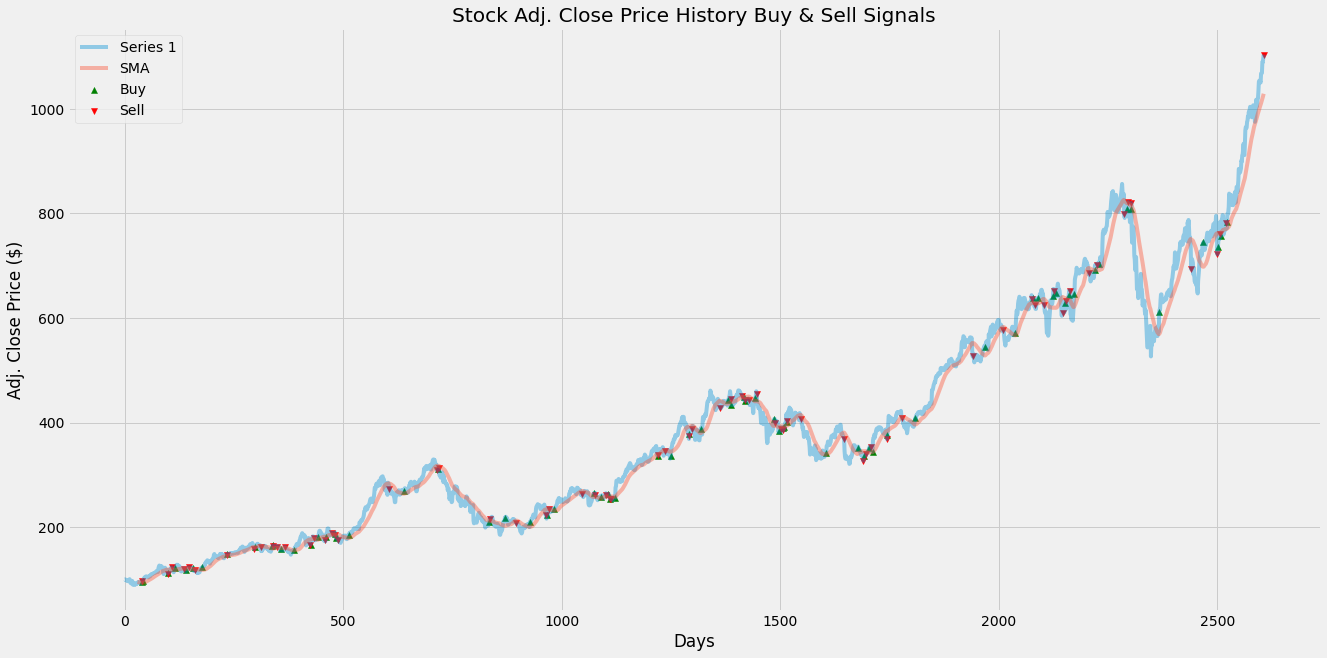

In [119]:
window =30
series = 'Series 1'
lag = 1
# =========================================

#Store the buy and sell data into a variable
buy_sell_data = rolling_averages_inflexions(df[series], window)

# visualise test
plt.figure(figsize=(20, 10))
plt.plot(df[series], label=series, alpha=0.4)
plt.plot(df[series].rolling(window=window).mean(), label='SMA', alpha=0.4)
plt.scatter(df.index, buy_sell_data[0], label='Buy', marker='^', color='green')
plt.scatter(df.index, buy_sell_data[1], label='Sell', marker='v', color='red')
plt.title('Stock Adj. Close Price History Buy & Sell Signals')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(loc='upper left')
plt.show()

In [57]:
def Backtest(data, buy_sell):
    profit = np.nansum(buy_sell[1]) - np.nansum(buy_sell[0])
    data_profit = data.iloc[-1] - data[0]
    rel_profit = profit - data_profit
    
    return rel_profit


In [130]:
def Backtest(data,data_buy_sell_data):
    profit = 0
    buy_signals = buy_sell_data[0]
    sell_signals = buy_sell_data[1]

    for i in range(1,len(buy_sell_data[2])): 

        if buy_sell_data[2][i]==buy_sell_data[2][i-1]:
            #no change
            pass

        elif buy_sell_data[2][i] == 1 and buy_sell_data[2][i-1]==-1:
            #from nothing to long
            price_bought_at = data[i]
            pass

        elif buy_sell_data[2][i] == 0 and buy_sell_data[2][i-1]==1:
            #from long to short
            profit += df[series][i]-price_bought_at
            price_shorted_at = data[i]

        elif buy_sell_data[2][i] == 1 and buy_sell_data[2][i-1]==0:
            #from short to long
            profit += price_shorted_at - df[series][i]  
            price_bought_at = data[i]   

    return profit  
    #if np.isnan(num)==False:
        #pass
    #else:
        #profit_buys += buy_sell_data[0][i]-

In [131]:
def profit_fct_inflection_points(input_window):
    
    """
    parameters that can be modified 
    """

    eg_series = 'Series 1'
    assets = list(df.columns)
    lag=0
    window = input_window
    profit = {}
    for i in assets:
        profit_on_series = Backtest(df[i],rolling_averages_inflexions(df[i], window))
        profit[i]=profit_on_series
    return profit

In [132]:
profit_inflexion = profit_fct_inflection_points(2)

In [133]:
profit_inflexion

{'Series 1': 209.34841158107372,
 'Series 2': 248.08538414864603,
 'Series 3': -204.5142295389208,
 'Series 4': -1.1325708160195234,
 'Series 5': -10.544635683111665,
 'Series 6': -352.091728626381,
 'Series 7': -238.04875177861385,
 'Series 8': 341.1903835503158,
 'Series 9': -206.71369716203134,
 'Series 10': -250.11532421525476,
 'Series 11': -188.287460231951,
 'Series 12': -33.65976884225745,
 'Series 13': -365.7448067807377,
 'Series 14': 247.50089212330238,
 'Series 15': -235.95460542343392,
 'Series 16': -152.17888406994092,
 'Series 17': -171.0406291622495,
 'Series 18': -273.7036866445466,
 'Series 19': -271.67578399678416,
 'Series 20': -247.949114155115,
 'Series 21': -219.2150559846408,
 'Series 22': -252.0447423392086,
 'Series 23': -241.62364052409447,
 'Series 24': -242.0693552581609,
 'Series 25': -169.70932726529924,
 'Series 26': -207.02982463809155,
 'Series 27': -203.9546846678748,
 'Series 28': 300.62440766993836,
 'Series 29': -279.168992542624}

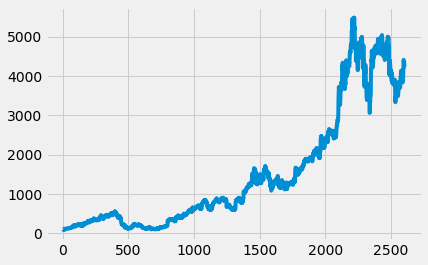

In [62]:
plt.plot(df['Series 13'])